# Natural Language Processing with Disaster Tweets

To get started with the classification task we need to observe our data, for this we use a DataFrame.

In [1]:
import pandas as pd

train_csv = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

We inspect our DataFrame, recognize our label which we will turn into 'y' later.  
For this task initially i have decided to only use our 'text' feature considering it's importance.  
The datapoints under text represent the tweets, for this task this holds the most information by far given all our features.  

It might have value to add the remaining 2 features, but they containt a lot of NaN values.  

In [2]:
train_csv

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Lets check datapoint nr. 35  
Here we see:  
- keyword
- location
- text

In [3]:
for tweet in train_csv['keyword'][35:36]: print(tweet)
for tweet in train_csv['location'][35:36]: print(tweet)    
for tweet in train_csv['text'][35:36]: print(tweet)

ablaze
London, UK
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N


X represents our dataset, and y represents our labels.  
We create a dataframe that holds both.

In [4]:
X_y = train_csv[["text","target"]].copy()

X_y

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


# PreProcessing  
We now have to test if our datapoints hold any NaN values.  
We assume our labels 'target' dont hold any, in case they do, we'd have to correct this else supervised training is not possible.  

We test this through a simple loop, shown below.  

In [5]:
for col in X_y:
    if X_y[col].isnull().any(): print(f"NaN values are present in {col}")
    else: print(f"No NaN values in {col}")

# Alternatively we can use list comprehension.
[col for col in X_y if X_y[col].isnull().any()]

No NaN values in text
No NaN values in target


[]

This is good news, we don't need to worry about imputation.  
Meaning that the next step is cleaning up our single feature column to make it more effective.  
NLTK has many tricks to represent our data.    

But first we will do some manual work.  
- Remove numbers 
- Remove punctuation
- Convert to lowercase

Let's take a look at some example tweets first

In [6]:
for tweet in X_y['text'].head(): print(tweet)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


our machine considers 'ALLAH' and 'allah' as well as other variations such as 'Allah' to all be seperate words.  
To fix this first we convert everything to lowercase. 
Something as seen below:  

In [7]:
for tweet in X_y['text'].head(): print(tweet.lower())

our deeds are the reason of this #earthquake may allah forgive us all
forest fire near la ronge sask. canada
all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in california 
just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school 


To implement this, we do the following:

In [8]:
X_y['text'] = X_y['text'].str.lower()

As we can see our DataFrame is succesfully converted.  

In [9]:
X_y

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask. canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @thetawniest the out of control w...,1
7610,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,police investigating after an e-bike collided ...,1


Next we'll be using a regex to remove all non-letter characters from 'text' column.

In [10]:
X_y['text'] = X_y['text'].str.replace('[^a-zA-Z\s]', '', regex=True)

We can observe our final product below. But there are still ways NLTK can help us work better with feature extraction...

In [11]:
for tweet in X_y['text'].head(): print(tweet.lower())

our deeds are the reason of this earthquake may allah forgive us all
forest fire near la ronge sask canada
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
 people receive wildfires evacuation orders in california 
just got sent this photo from ruby alaska as smoke from wildfires pours into a school 


# NLTK

The first thing we apply is filtering stop words, words without much meaningful information such as "the, with, and..."  
Doing this makes our dataset much more efficient which might not be neccessary for small scale projects as these, but is a good practice.

In [12]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stopwords(text):
    words = text.split()  
    filtered_words = [word for word in words if word not in stop]  
    return ' '.join(filtered_words)  

X_y['text'] = X_y['text'].apply(remove_stopwords)

As seen below we can still read the sentences and extract the message from it, not much of value is lost.

In [13]:
for tweet in X_y['text'].head(): print(tweet.lower())

deeds reason earthquake may allah forgive us
forest fire near la ronge sask canada
residents asked shelter place notified officers evacuation shelter place orders expected
people receive wildfires evacuation orders california
got sent photo ruby alaska smoke wildfires pours school


Now we will do the same but for something called stemming, which might make things harder for us but helps machines.

In [14]:
from nltk.tokenize import word_tokenize
X_y['text'] = X_y['text'].apply(word_tokenize)


In [15]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
def stem_words(words):
    filtered_words = [stemmer.stem(word) for word in words]
    return ' '.join(filtered_words)

X_y['text'] = X_y['text'].apply(stem_words)

In [16]:
for tweet in X_y['text'].head(): print(tweet.lower())

deed reason earthquak may allah forgiv us
forest fire near la rong sask canada
resid ask shelter place notifi offic evacu shelter place order expect
peopl receiv wildfir evacu order california
got sent photo rubi alaska smoke wildfir pour school


stemming takes words to a more basic form, even ones that aren't correct in reality. But this does not matter, what matters is that the machine can recognize relations in words.  
With stemming the machine can link together 'forgiving' and 'forgiveness', but without stemming has a harder time.

# Vectorizing

With our data being preprocessed the next step is converting it to matrix form so our machine can be trained in ways ML models prefer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(X_y['text'])
y = X_y['target']

a few things to note here:  
- X is our dataset excluding our label, which in this case is just our 'text' feature.  
- y is our label, this contains the true value of what we're trying to predict.
- max_features is a hyperparameter.

# Machine Learning Models

First thing to do is splitting our data to check our models performance during training.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
accuracy_scores = {}

**Random Forest Model**

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_scores['Random Forest'] = accuracy_score(y_test, y_pred_rf)
print("Random Forest: ")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_scores['Random Forest'])

Random Forest: 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1318
           1       0.77      0.69      0.73       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284

Accuracy: 0.7832749562171629


**Naive Bayes**

In [21]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
accuracy_scores['Naive Bayes'] = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes: ")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_scores['Naive Bayes'])

Naive Bayes: 
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284

Accuracy: 0.808231173380035


**Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_scores['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression: ")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_scores['Logistic Regression'])

Logistic Regression: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1318
           1       0.84      0.68      0.75       966

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284

Accuracy: 0.8086690017513135


**Support Vector Machine**

In [23]:
from sklearn.svm import SVC

model_svm = SVC(kernel='linear', random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
accuracy_scores['Support Vector'] = accuracy_score(y_test, y_pred_svm)
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_scores['Support Vector'])

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1318
           1       0.81      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Accuracy: 0.8003502626970228


**Multi Layer Perceptron**  
First we create a simple variant and observe

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_mlp.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

loss, accuracy = model_mlp.evaluate(X_test, y_test)
accuracy_scores['Neural Network'] = accuracy
print(f'Test Accuracy: {accuracy:.4f}')

y_pred_mlp = model_mlp.predict(X_test)
y_pred_classes = (y_pred_mlp > 0.5).astype(int)

report = classification_report(y_test, y_pred_classes, target_names=['Non-Disaster', 'Disaster'])
print(report)

2024-08-06 16:50:18.226691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 16:50:18.226754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 16:50:18.228407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6240 - loss: 0.6357 - val_accuracy: 0.7824 - val_loss: 0.4636
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8721 - loss: 0.3096 - val_accuracy: 0.7824 - val_loss: 0.4717
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9382 - loss: 0.1736 - val_accuracy: 0.7786 - val_loss: 0.5649
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9700 - loss: 0.0922 - val_accuracy: 0.7767 - val_loss: 0.6792
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9760 - loss: 0.0621 - val_accuracy: 0.7786 - val_loss: 0.7540
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9784 - loss: 0.0508 - val_accuracy: 0.7805 - val_loss: 0.8760
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9813 - loss: 0.0459 - val_accuracy: 0.7880 - val_loss: 0.9546
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9798 - loss: 0.0412 - val_accuracy: 0.

Then we apply some techniques to optimize performance

In [25]:
model_nn_plus = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model_nn_plus.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

model_nn_plus.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

loss, accuracy = model_nn_plus.evaluate(X_test, y_test)
accuracy_scores['Boosted NN'] = accuracy
print(f'Test Accuracy: {accuracy:.4f}')

y_pred_mlp = model_nn_plus.predict(X_test)
y_pred_classes = (y_pred_mlp > 0.5).astype(int)

report = classification_report(y_test, y_pred_classes, target_names=['Non-Disaster', 'Disaster'])
print(report)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5649 - loss: 0.6763 - val_accuracy: 0.7692 - val_loss: 0.4943
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8275 - loss: 0.4238 - val_accuracy: 0.7955 - val_loss: 0.4490
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8953 - loss: 0.2824 - val_accuracy: 0.7861 - val_loss: 0.4778
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9248 - loss: 0.2001 - val_accuracy: 0.7880 - val_loss: 0.5218
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9415 - loss: 0.1649 - val_accuracy: 0.7824 - val_loss: 0.5859
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7861 - loss: 0.4709
Test Accuracy: 0.7964
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

Non-Disaster       0.81      0.84      0.83      1318
    Disaster       0.77      0.74      0.75       966

    accuracy                           0.80      2284
   macro avg       

# **Voting Classifier**

In [26]:
from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier(estimators=[('rf', model_rf), ('nb', model_nb), ('lr', model_lr), ('svm', model_svm)], voting='hard')
voting_classifier.fit(X_train, y_train)

y_pred_vc = voting_classifier.predict(X_test)
accuracy_scores['Voting Classifier'] = accuracy_score(y_test, y_pred_vc)
print("Voting Classifier: ")
print(classification_report(y_test, y_pred_vc))
print("Accuracy:", accuracy_scores['Voting Classifier'])

Voting Classifier: 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1318
           1       0.86      0.66      0.75       966

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.80      2284
weighted avg       0.82      0.81      0.81      2284

Accuracy: 0.8108581436077058


Neural network MLP
add other features to words

# Test Data Conversion

In [27]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

test_df['text'] = test_df['text'].str.lower()  
test_df['text'] = test_df['text'].str.replace('[^a-zA-Z\s]', '', regex=True)

test_df['text'] = test_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(word_tokenize)
test_df['text'] = test_df['text'].apply(stem_words)

test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,happen terribl car crash
1,2,NaN,NaN,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,forest fire spot pond gees flee across street ...
3,9,NaN,NaN,apocalyps light spokan wildfir
4,11,NaN,NaN,typhoon soudelor kill china taiwan


# Submission: Voting Classifier

In [28]:
test = tfidf.transform(test_df['text'])
test_df['target'] = voting_classifier.predict(test)

In [29]:
results = test_df[['id', 'target']]
results.to_csv('nlp_disaster_submission.csv', index=False)

results

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


# Submission: MLP Classifier

In [30]:
import numpy as np 

test_mlp_pred = np.squeeze(model_mlp.predict(test))
test_df['target'] = (test_mlp_pred > 0.5).astype(int)

results = test_df[['id', 'target']]
results.to_csv('mlp_disaster_submission.csv', index=False)

results

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,0


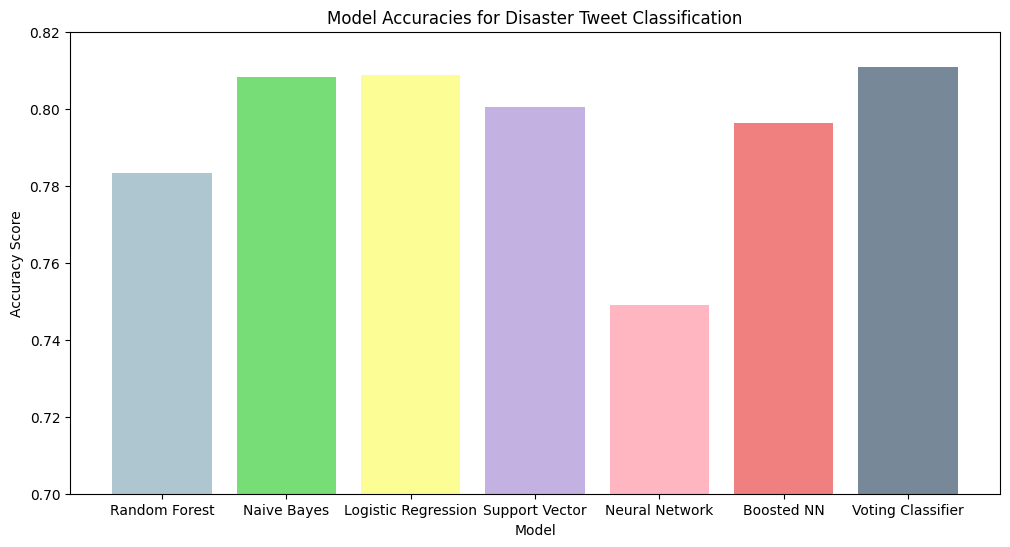

In [31]:
import matplotlib.pyplot as plt

# Plot the accuracies
plt.figure(figsize=(12, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color = ['#AEC6CF', '#77DD77', '#FDFD96', '#C3B1E1', '#FFB6C1', '#F08080', '#778899'])
plt.title('Model Accuracies for Disaster Tweet Classification')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0.70, 0.82)  
plt.xticks(rotation=0)
plt.show()